In [6]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np
import tensorflow_model_optimization as tfmot

set_seed(1234)

# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [7]:
dataset_name = DatasetName.RADIOML_2016
radioml2016b_path = cur_dir + "/data/radioml_2016/RML2016.10b.dat"
radioml2016a_path = cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl"
dataset_path = os.path.abspath(radioml2016b_path)
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path, expand2d=True)
# radioml_ds.load(dataset_path, expand2d=False)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)
print(f"Modulations: {radioml_ds.get_modulations()}")

{'8PSK': 0, 'AM-DSB': 1, 'BPSK': 2, 'CPFSK': 3, 'GFSK': 4, 'PAM4': 5, 'QAM16': 6, 'QAM64': 7, 'QPSK': 8, 'WBFM': 9}
Modulations: ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


# Create Model
Create convolutional model

In [8]:
# reload_module("models.cnn.cnn_1d_v014")
# reload_module("models.layers.custom_batch_norm")
# reload_module("models.fabric")
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName
from evaluation.results_serialization import load_results

model_name = "cnn_1d_v012_small_radio_ml16b_q_aware_test_batch_norm"
train_model = True
q_aware = True

quantize_model = tfmot.quantization.keras.quantize_model

if train_model:
    cnn_1d_v012_3_configuration = Convolution01xConfiguration(
        input_shape=(1, 128, 2),
        # input_shape=(128, 2),
        n_classes=len(radioml_ds.get_modulations()),
        output_channels=[16, 32, 48, 64, 96],
        kernel_sizes=[8, 8, 8, 8, 8],
        paddings=["same", "same", "same", "same", "same",],
        max_pool_sizes=[2, 1, 2, 1, 2],
        max_pool_strides=[2, 1, 2, 1, 2],
        avg_size=16,
        dense_sizes=[96],
    )

    model_configuration = cnn_1d_v012_3_configuration

    model = make_sigmod_model(ModelName.CNN_1D_V013, model_configuration)
    # model = make_sigmod_model(ModelName.CNN_1D_V012, model_configuration)

    model.summary()

else:
    results = load_results(model_name + "_results/", load_model=True)
    model = results["model"]
    


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 128, 2)]       0         
                                                                 
 CNN0_ (Conv2D)              (None, 1, 128, 16)        272       
                                                                 
 MAX_POOL_0_ (MaxPooling2D)  (None, 1, 64, 16)         0         
                                                                 
 CNN_REL0_ (ReLU)            (None, 1, 64, 16)         0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 64, 32)         4128      
                                                                 
 MAX_POOL_1_ (MaxPooling2D)  (None, 1, 64, 32)         0         
                                                                 
 CNN_REL1_ (ReLU)            (None, 1, 64, 32)         0   

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [9]:
import tensorflow as tf

def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    # if (epoch > 16):
    #     return 0.0005
    return 0.001
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


if train_model:
    lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # N_EPOCHS = 16
    # N_EPOCHS = 48
    N_EPOCHS = 20
    # N_EPOCHS = 7
    BATCH_SIZE = 256

    h = model.fit(
        splitted_radioml_ds.train.data,
        splitted_radioml_ds.train.labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
        callbacks=[lrate]
    )


2023-08-27 17:58:27.041898: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 937.50MiB (rounded to 983040000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-27 17:58:27.041938: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-08-27 17:58:27.041946: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 1.4KiB client-requested in use in bin.
2023-08-27 17:58:27.041951: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 4, Chunks in use: 4. 2.0KiB allocated for chunks. 2.0KiB in use in bin. 1.5KiB client-requested in use in bin.
2023-08-27 17:58:27.041955: I tensorflow/tsl/framework/b

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

e in bin.
2023-08-27 17:58:27.041980: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (32768): 	Total Chunks: 5, Chunks in use: 4. 228.0KiB allocated for chunks. 168.0KiB in use in bin. 168.0KiB client-requested in use in bin.
2023-08-27 17:58:27.041985: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (65536): 	Total Chunks: 3, Chunks in use: 2. 288.0KiB allocated for chunks. 192.0KiB in use in bin. 192.0KiB client-requested in use in bin.
2023-08-27 17:58:27.041990: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (131072): 	Total Chunks: 3, Chunks in use: 2. 528.0KiB allocated for chunks. 384.0KiB in use in bin. 384.0KiB client-requested in use in bin.
2023-08-27 17:58:27.041994: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (262144): 	Total Chunks: 1, Chunks in use: 0. 384.0KiB allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-08-27 17:58:27.041999: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (524288): 	Total Chunks: 0

## Fine tune model

In [ ]:
if q_aware:
    print("Model is quantization aware")
    q_aware_model = quantize_model(model)
else:
    print("Model is NOT quantization aware")

q_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

Model is quantization aware


In [ ]:
q_aware_model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=6,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
)

Epoch 1/6
3750/3750 [==============================] - 44s 11ms/step - loss: 0.9133 - accuracy: 0.6314 - val_loss: 0.9248 - val_accuracy: 0.6280
Epoch 2/6
3750/3750 [==============================] - 41s 11ms/step - loss: 0.9027 - accuracy: 0.6357 - val_loss: 0.9269 - val_accuracy: 0.6250
Epoch 3/6
3750/3750 [==============================] - 42s 11ms/step - loss: 0.9009 - accuracy: 0.6364 - val_loss: 0.9186 - val_accuracy: 0.6294
Epoch 4/6
3750/3750 [==============================] - 42s 11ms/step - loss: 0.8992 - accuracy: 0.6369 - val_loss: 0.9125 - val_accuracy: 0.6325
Epoch 5/6
3750/3750 [==============================] - 42s 11ms/step - loss: 0.8975 - accuracy: 0.6382 - val_loss: 0.9195 - val_accuracy: 0.6312
Epoch 6/6
3750/3750 [==============================] - 42s 11ms/step - loss: 0.8961 - accuracy: 0.6385 - val_loss: 0.9156 - val_accuracy: 0.6308


# Evaluation
Check train plots, confusion matrices, snr to accuracy

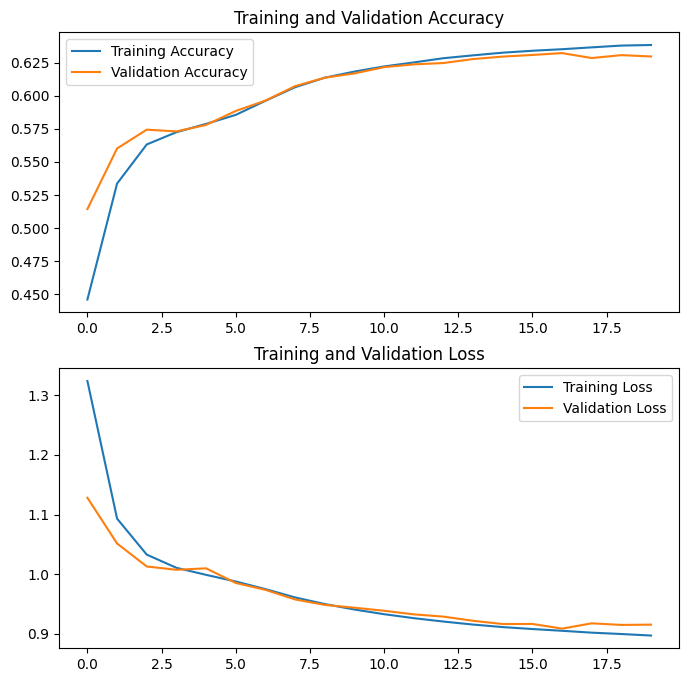

In [12]:
if train_model:
    from evaluation.vizualization import plot_train, plot_snr_to_acc
    plot_train(h.history)

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.631975}
8PSK test accuracy: 0.62824016563147
AM-DSB test accuracy: 0.7592333634942832
BPSK test accuracy: 0.6224591802732422
CPFSK test accuracy: 0.7100057932632624
GFSK test accuracy: 0.7405750269284945
PAM4 test accuracy: 0.7109957290009212
QAM16 test accuracy: 0.5923839946200403
QAM64 test accuracy: 0.664617429592091
QPSK test accuracy: 0.567318364210706
WBFM test accuracy: 0.3201663201663202
Confusion matrix:
[[7586  869  242 1123  948  172  363  190  426  156]
 [ 493 9230  104  405  620   54    6    9   62 1174]
 [ 871  855 7472  919  913  485   63   97  178  151]
 [ 892  818  189 8579 1002  125   80   67  160  171]
 [ 610  974  120  752 8938   86   19   28   79  463]
 [ 629  584  529  702  618 8490   66   94  111  118]
 [ 901  519  200  807  560  128 7047 1343  272  119]
 [ 653  320  134  547  339  145 1578 8000  233   88]
 [1294  842  258 1061  852  152  276  166 6645  167]
 [ 517 6219   79  428  793   52    7   12  

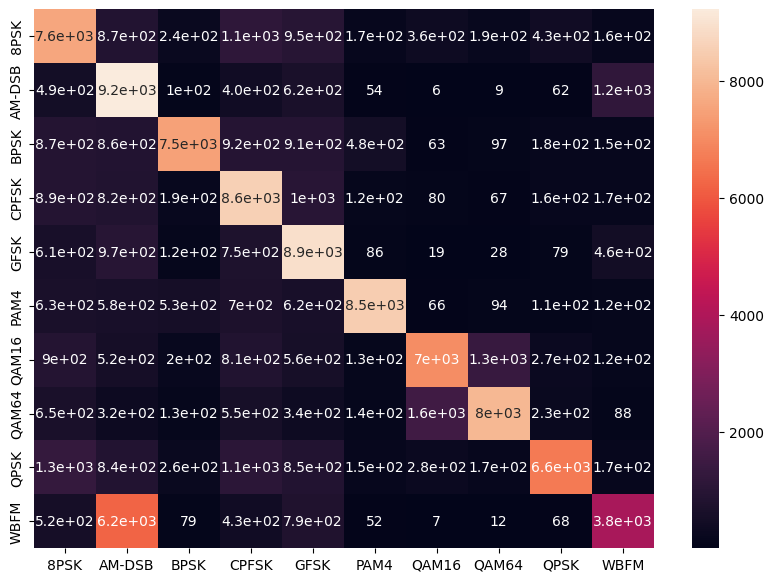

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6297416666666666}
8PSK test accuracy: 0.6204434111101885
AM-DSB test accuracy: 0.7518284574468085
BPSK test accuracy: 0.6265030267849738
CPFSK test accuracy: 0.7081737972365574
GFSK test accuracy: 0.7335763329660083
PAM4 test accuracy: 0.714759535655058
QAM16 test accuracy: 0.6008942129239075
QAM64 test accuracy: 0.6686584267823524
QPSK test accuracy: 0.5547779721736232
WBFM test accuracy: 0.31566143779884237
Confusion matrix:
[[7472  912  268 1112  963  152  362  196  463  143]
 [ 520 9046   93  392  621   68    4    8   46 1234]
 [ 945  831 7555  939  840  474   57   81  189  148]
 [ 889  830  189 8508 1032  118   76   78  135  159]
 [ 653  884  111  795 8654   84   16   29   87  484]
 [ 640  613  509  704  571 8620   80  101  113  109]
 [ 882  480  190  721  543  145 7123 1395  237  138]
 [ 628  339  148  564  330  128 1587 8169  235   89]
 [1357  891  261 1079  943  155  283  188 6659  187]
 [ 503 6198  107  450  783   

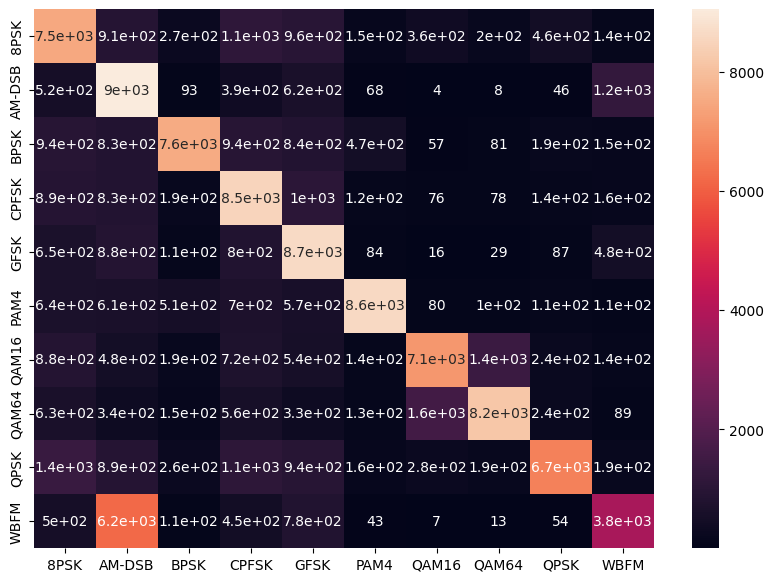

In [14]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.11652087803267866
SNR: -18 -- Overall test accuracy: 0.11170212765957446
SNR: -16 -- Overall test accuracy: 0.13454118436503942
SNR: -14 -- Overall test accuracy: 0.15906805229634596
SNR: -12 -- Overall test accuracy: 0.19439376347653012
SNR: -10 -- Overall test accuracy: 0.27471609886439546
SNR: -8 -- Overall test accuracy: 0.4076666666666667
SNR: -6 -- Overall test accuracy: 0.5558005427408412
SNR: -4 -- Overall test accuracy: 0.7090878883535471
SNR: -2 -- Overall test accuracy: 0.8210090984284533
SNR: 0 -- Overall test accuracy: 0.8787578460521969
SNR: 2 -- Overall test accuracy: 0.9110219100183977
SNR: 4 -- Overall test accuracy: 0.9205352717660664
SNR: 6 -- Overall test accuracy: 0.9216148023549201
SNR: 8 -- Overall test accuracy: 0.9215101838052657
SNR: 10 -- Overall test accuracy: 0.9139874047066623
SNR: 12 -- Overall test accuracy: 0.9188085106382978
SNR: 14 -- Overall test accuracy: 0.9217188540972685
SNR: 16 -- Overall test accuracy: 0.922

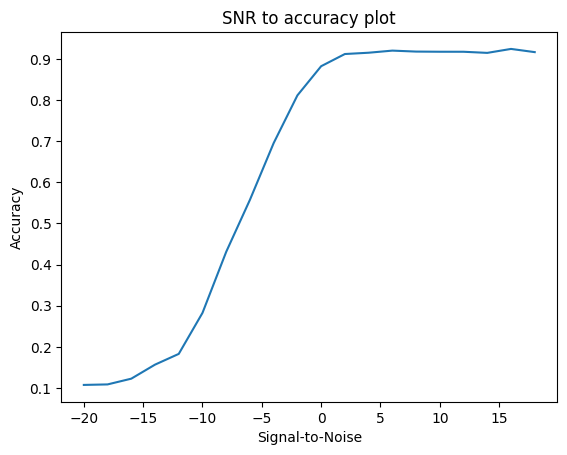

In [15]:
# reload_module("evaluation.metric_evaluation")
# from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_val)

# Save results

In [16]:
# reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))
# history = {}

dump_results(
    model_name + "_results/",
    model=model,
    model_config=model_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    short_description="Smaller + dense, 48 epochs with more decay (16:/=10, 24:/=4, 32: /=4)",
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

In [17]:
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_snr_to_acc

model_path = f"{model_name}_results/model_original"
model.save(model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)



INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml16b_q_aware_v3_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1d_v012_small_radio_ml16b_q_aware_v3_results/model_original/assets
2023-08-17 23:10:45.866857: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-17 23:10:45.866880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-17 23:10:45.867510: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml16b_q_aware_v3_results/model_original
2023-08-17 23:10:45.869349: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-17 23:10:45.869361: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml16b_q_aware_v3_results/model_original
2023-08-17 23:10:45.873846: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-17 23:10:45.875577: I tensorflow/cc/saved_m

In [18]:
# cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
#     model_tflile_no_quant,
#     splitted_radioml_ds.test.data,
#     splitted_radioml_ds.test.labels,
#     radioml_ds.get_modulations(),
#     predict_func=predict_tflite,
# )

reload_module("evaluation.metric_evaluation")
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation


# snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
#     model_tflile_no_quant,
#     splitted_radioml_ds.test.data,
#     splitted_radioml_ds.test.labels,
#     radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
#     predict_func=predict_tflite,
# )
# plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

2023-08-17 23:10:46.371204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-17 23:10:46.371233: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-17 23:10:46.371419: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml16b_q_aware_v3_results/model_original
2023-08-17 23:10:46.373217: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-17 23:10:46.373229: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml16b_q_aware_v3_results/model_original
2023-08-17 23:10:46.379789: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-17 23:10:46.432144: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_1d_v012_small_radio_ml16b_q_aware_v3_results/model_original

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.609075}
8PSK test accuracy: 0.7330020703933747
AM-DSB test accuracy: 0.7410545364810397
BPSK test accuracy: 0.6415361546151283
CPFSK test accuracy: 0.673425473806174
GFSK test accuracy: 0.6370867511807109
PAM4 test accuracy: 0.690310694246713
QAM16 test accuracy: 0.616930060524546
QAM64 test accuracy: 0.4992938439810584
QPSK test accuracy: 0.541961922650047
WBFM test accuracy: 0.3128482328482328
Confusion matrix:
[[8851 1172  470  695  232  122  200   41  244   48]
 [1227 9009  126  207  146   26    2    0    4 1410]
 [1997 1182 7701  472  228  329   29   11   18   37]
 [1988 1135  305 8137  293   72   34    8   29   82]
 [1558 1641  212  443 7689   50   10    2   13  451]
 [1449  839  800  346  168 8243   37   11   14   34]
 [1806  744  389  560  161  142 7339  581  126   48]
 [1257  482  333  434  129  159 3080 6010  111   42]
 [2532 1086  479  728  203  113  137   22 6348   65]
 [1221 6390  121  219  270   25    8    1  

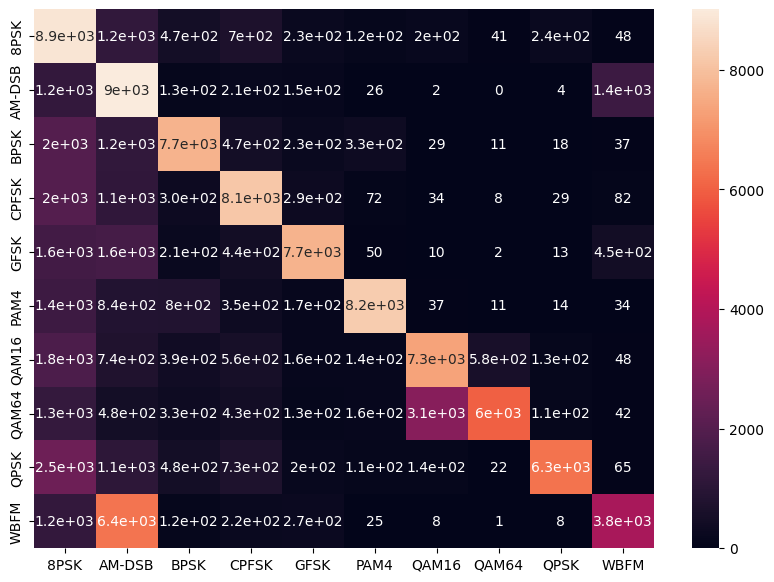

SNR: -20 -- Overall test accuracy: 0.10694834131044727
SNR: -18 -- Overall test accuracy: 0.11702127659574468
SNR: -16 -- Overall test accuracy: 0.11843650394229156
SNR: -14 -- Overall test accuracy: 0.13576935970499499
SNR: -12 -- Overall test accuracy: 0.1610549013103334
SNR: -10 -- Overall test accuracy: 0.22895791583166333
SNR: -8 -- Overall test accuracy: 0.354
SNR: -6 -- Overall test accuracy: 0.5181478968792401
SNR: -4 -- Overall test accuracy: 0.6871573351054993
SNR: -2 -- Overall test accuracy: 0.8021505376344086
SNR: 0 -- Overall test accuracy: 0.8686818632309217
SNR: 2 -- Overall test accuracy: 0.8924569325974243
SNR: 4 -- Overall test accuracy: 0.899388732859739
SNR: 6 -- Overall test accuracy: 0.903448275862069
SNR: 8 -- Overall test accuracy: 0.9008113926146714
SNR: 10 -- Overall test accuracy: 0.8907855485581704
SNR: 12 -- Overall test accuracy: 0.8966808510638298
SNR: 14 -- Overall test accuracy: 0.8982345103264491
SNR: 16 -- Overall test accuracy: 0.900016719612105
SNR

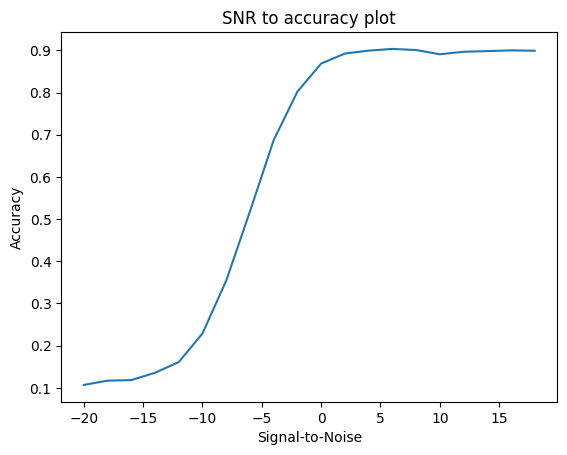

In [19]:
# reload_module("deployment_tools")
from deployment_tools import to_tf_lite, predict_tflite

representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)

In [13]:
interpreter = tf.lite.Interpreter(model_content=model_tflile)
print(interpreter.get_input_details()[0])
print(interpreter.get_output_details()[0])

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   2], dtype=int32), 'shape_signature': array([ -1, 128,   2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0004541363741736859, -4), 'quantization_parameters': {'scales': array([0.00045414], dtype=float32), 'zero_points': array([-4], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 53, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [18]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


10it [00:00, 1619.42it/s]